In [38]:
# Which Actors appear most frequently in high-rated movies (e.g., IMDb ratings > 7)

# Import Libraries
import requests
import json
import matplotlib.pyplot as plt
import pandas as pd
import ast
from pprint import pprint
from config import tmdb_api_key
from config import omdb_api_key

# TMDB Setup 

# t_api_key = tmdb_api_key
# t_base_url = "https://api.themoviedb.org/3/discover/movie"

# Import The Movie Dataset CSVs into Dataframes
credits_df = pd.read_csv("Resources/credits.csv")
keywords_df = pd.read_csv("Resources/keywords.csv")
links_small_df = pd.read_csv("Resources/links_small.csv")
links_df = pd.read_csv("Resources/links.csv")
movies_df = pd.read_csv("Resources/movies_metadata.csv")
ratings_small_df = pd.read_csv("Resources/ratings_small.csv")
ratings_df = pd.read_csv("Resources/ratings.csv")



C:\Users\flash\AppData\Local\Temp\ipykernel_1968\1853352243.py:23: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_df = pd.read_csv("Resources/movies_metadata.csv")


In [46]:
pprint(credits_df)

                                                    cast  \
0      [{'cast_id': 14, 'character': 'Woody (voice)',...   
1      [{'cast_id': 1, 'character': 'Alan Parrish', '...   
2      [{'cast_id': 2, 'character': 'Max Goldman', 'c...   
3      [{'cast_id': 1, 'character': "Savannah 'Vannah...   
4      [{'cast_id': 1, 'character': 'George Banks', '...   
...                                                  ...   
45471  [{'cast_id': 0, 'character': '', 'credit_id': ...   
45472  [{'cast_id': 1002, 'character': 'Sister Angela...   
45473  [{'cast_id': 6, 'character': 'Emily Shaw', 'cr...   
45474  [{'cast_id': 2, 'character': '', 'credit_id': ...   
45475                                                 []   

                                                    crew      id  
0      [{'credit_id': '52fe4284c3a36847f8024f49', 'de...     862  
1      [{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...    8844  
2      [{'credit_id': '52fe466a9251416c75077a89', 'de...   15602  
3      [{'c

In [42]:
# Dropping unneeded columns for movie dataframe
clean_movies_df = movies_df.drop(columns=["adult", 
                                          "belongs_to_collection", 
                                          "budget", 
                                          "genres", 
                                          "homepage", 
                                          "original_language", 
                                          "overview",
                                          "popularity",
                                          "poster_path",
                                          "production_companies",
                                          "production_countries",
                                          "revenue", 
                                          "runtime", 
                                          "spoken_languages", 
                                          "status", 
                                          "tagline", 
                                          "video"])

Dropping Cast Column
clean_credits_df = credits_df.drop(columns = ["crew"])

In [5]:
# Converting 'cast' column from strings to Python objects
clean_credits_df['cast'] = clean_credits_df['cast'].apply(ast.literal_eval)

In [6]:
# Extract actor names
actor_names_df = clean_credits_df['cast'].apply(lambda x: [person['name'] for person in x])

# Setting the max number of actors per movie to 5
max_actors = 5

#Filling in list with "None" to make sure all rows have the same number of actors
actor_names_df = actor_names_df.apply(lambda x: x[:max_actors] + [None] * (max_actors - len(x)))

# Inserting actors in their own column
actor_columns = pd.DataFrame(actor_names_df.tolist(), 
                             columns=[f'actor_{i+1}' for i in range(max_actors)])

# Aligning indexes
actor_columns.index = clean_credits_df.index

# Merging the new actor columns with the original DataFrame
actor_results_df = pd.concat([clean_credits_df, actor_columns], axis=1)

# Removing old cast column
actor_results_df = actor_results_df.drop(columns=['cast'])

# Print the result
actor_results_df.head()


,id,actor_1,actor_2,actor_3,actor_4,actor_5
0,862,Tom Hanks,Tim Allen,Don Rickles,Jim Varney,Wallace Shawn
1,8844,Robin Williams,Jonathan Hyde,Kirsten Dunst,Bradley Pierce,Bonnie Hunt
2,15602,Walter Matthau,Jack Lemmon,Ann-Margret,Sophia Loren,Daryl Hannah
3,31357,Whitney Houston,Angela Bassett,Loretta Devine,Lela Rochon,Gregory Hines
4,11862,Steve Martin,Diane Keaton,Martin Short,Kimberly Williams-Paisley,George Newbern


In [7]:
# Cleaning up invalid entries
clean_movies_df['id'] = pd.to_numeric(clean_movies_df['id'], errors='coerce')
actor_results_df['id'] = pd.to_numeric(actor_results_df['id'], errors='coerce')
clean_movies_df = clean_movies_df.dropna(subset=['id'])
actor_results_df = actor_results_df.dropna(subset=['id'])

# Setting id column to int
clean_movies_df['id'] = clean_movies_df['id'].astype(int)
actor_results_df['id'] = actor_results_df['id'].astype(int)

# Merge
merged_movie_df = pd.merge(clean_movies_df, actor_results_df, how='left', on='id')
merged_movie_df.head()

,id,imdb_id,original_title,release_date,title,vote_average,vote_count,actor_1,actor_2,actor_3,actor_4,actor_5
0,862,tt0114709,Toy Story,1995-10-30,Toy Story,7.7,5415.0,Tom Hanks,Tim Allen,Don Rickles,Jim Varney,Wallace Shawn
1,8844,tt0113497,Jumanji,1995-12-15,Jumanji,6.9,2413.0,Robin Williams,Jonathan Hyde,Kirsten Dunst,Bradley Pierce,Bonnie Hunt
2,15602,tt0113228,Grumpier Old Men,1995-12-22,Grumpier Old Men,6.5,92.0,Walter Matthau,Jack Lemmon,Ann-Margret,Sophia Loren,Daryl Hannah
3,31357,tt0114885,Waiting to Exhale,1995-12-22,Waiting to Exhale,6.1,34.0,Whitney Houston,Angela Bassett,Loretta Devine,Lela Rochon,Gregory Hines
4,11862,tt0113041,Father of the Bride Part II,1995-02-10,Father of the Bride Part II,5.7,173.0,Steve Martin,Diane Keaton,Martin Short,Kimberly Williams-Paisley,George Newbern


In [8]:
# Putting the 5 actors into their own column with a repeating ID
merged_movie_df = merged_movie_df.melt(
    id_vars=['id', 'imdb_id', 'original_title', 'release_date', 'title', 'vote_average', 'vote_count'], 
    value_vars=['actor_1', 'actor_2', 'actor_3', 'actor_4', 'actor_5'],  
    value_name='actor'  
)

# Applying Vote Average Filter
filtered_merged_movie_df = merged_movie_df[merged_movie_df['vote_average'] > 7]
actor_appearance_counts = filtered_merged_movie_df['actor'].value_counts()

# Display the top 20 actors 
actor_appearance_counts_df = actor_appearance_counts.reset_index()
actor_appearance_counts_df.columns = ['actor', 'appearance_count']
actor_appearance_counts_df.rename(columns={'actor': 'Actor', 'appearance_count': '# of Appearances'}, inplace=True)
actor_appearance_counts_df.head(20)

,Actor,# of Appearances
0,Robert De Niro,26
1,Bette Davis,26
2,Toshirō Mifune,23
3,Tom Hanks,21
4,Christopher Plummer,20
5,James Stewart,20
6,Werner Herzog,20
7,Humphrey Bogart,19
8,Clint Eastwood,19
9,Catherine Deneuve,19


In [9]:
# Double checking our results
filtered_actor = merged_movie_df[
    (merged_movie_df['actor'] == 'Robert De Niro') & (merged_movie_df['vote_average'] > 7)
     ]
filtered_actor.sort_values(by='vote_average', ascending=False)

,id,imdb_id,original_title,release_date,title,vote_average,vote_count,variable,actor
20567,103162,tt0175844,Lenny Bruce: Swear to Tell the Truth,1998-10-21,Lenny Bruce: Swear to Tell the Truth,9.5,1.0,actor_1,Robert De Niro
137798,240,tt0071562,The Godfather: Part II,1974-12-20,The Godfather: Part II,8.3,3418.0,actor_4,Robert De Niro
1187,311,tt0087843,Once Upon a Time in America,1984-02-16,Once Upon a Time in America,8.3,1104.0,actor_1,Robert De Niro
1173,769,tt0099685,GoodFellas,1990-09-12,GoodFellas,8.2,3211.0,actor_1,Robert De Niro
109,103,tt0075314,Taxi Driver,1976-02-07,Taxi Driver,8.1,2632.0,actor_1,Robert De Niro
1221,11778,tt0077416,The Deer Hunter,1978-12-08,The Deer Hunter,7.8,943.0,actor_1,Robert De Niro
15,524,tt0112641,Casino,1995-11-22,Casino,7.8,1343.0,actor_1,Robert De Niro
1188,1578,tt0081398,Raging Bull,1980-11-14,Raging Bull,7.7,968.0,actor_1,Robert De Niro
45544,949,tt0113277,Heat,1995-12-15,Heat,7.7,1886.0,actor_2,Robert De Niro
46699,68,tt0088846,Brazil,1985-02-20,Brazil,7.6,877.0,actor_2,Robert De Niro


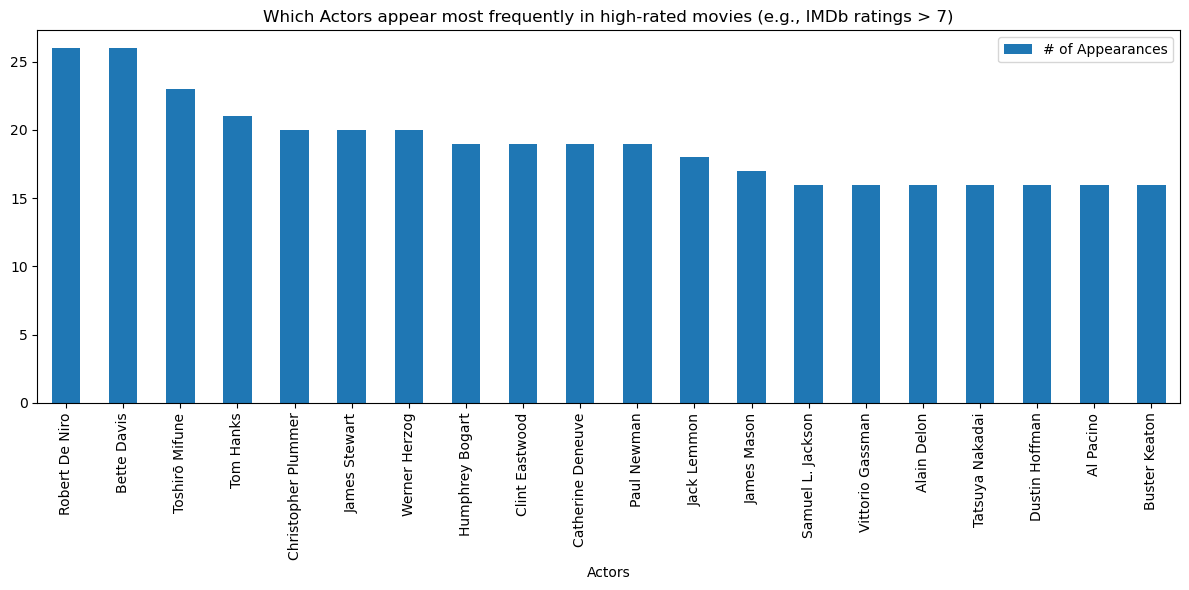

In [36]:
# Visualization of Most appearances in movies with a score of 7+ IMDB
actor_appearance_counts_df.head(20).plot.bar(x='Actor', y='# of Appearances', figsize=(12,6), width=0.5)
plt.title('Which Actors appear most frequently in high-rated movies (e.g., IMDb ratings > 7)')
plt.xlabel('Actors')
plt.tight_layout()
plt.show()